# DS Challenge
## Prediciendo el Pase usado para un Servicio Compartido de Bicicletas.

En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca del uso del servicio que ofrecen. La tabla que se proporciona contiene el histórico de viajes que se han realizado durante cerca de 9 meses.

Para el problema analítico, se desea saber si es posible inferir si el tipo de pase es “Monthly Pass” tomando en cuenta las demás variables de viaje.

Los datos y la demás información del problema se pueden encontrar en [Kaggle](https://www.kaggle.com/competitions/ds-programming-test/overview)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score 
import lightgbm as lgb
import haversine as hs

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
train = pd.read_csv("ds-programming-test/train_set.csv")
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


## 1. Análisis Exploratorio de Datos

### Datos Generales
¿Cuáles son los tipos de pases más comunes?

In [3]:
train.passholder_type.value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

¿Cuántos datos hay? ¿Hay datos repetidos?

In [4]:
len(train.trip_id)

700000

In [5]:
len(train.trip_id.unique())

700000

Antes de analizar `start_time` y `end_time`, hay que corregir los formatos, ´para que sean uniformes.

In [6]:
train["start_time"].head()

0    2018-08-07 11:20:00
1        9/17/2017 17:51
2    2019-04-22 09:22:00
3        9/22/2019 11:27
4        1/31/2020 17:11
Name: start_time, dtype: object

In [7]:
train["end_time"].head()

0    2018-08-07 11:55:00
1        9/17/2017 18:23
2    2019-04-22 09:28:00
3        9/22/2019 13:45
4        1/31/2020 17:25
Name: end_time, dtype: object

In [8]:
train["start_time"] = pd.to_datetime(train.start_time)
train["end_time"] = pd.to_datetime(train.end_time)
train[["start_time", "end_time"]].head()

,start_time,end_time
0,2018-08-07 11:20:00,2018-08-07 11:55:00
1,2017-09-17 17:51:00,2017-09-17 18:23:00
2,2019-04-22 09:22:00,2019-04-22 09:28:00
3,2019-09-22 11:27:00,2019-09-22 13:45:00
4,2020-01-31 17:11:00,2020-01-31 17:25:00


¿Cómo se relacionan `trip_route_category` y `passholder_type`?

In [9]:
pd.crosstab(train.trip_route_category, train.passholder_type)

passholder_type,Annual Pass,Flex Pass,Monthly Pass,One Day Pass,Testing,Walk-up
trip_route_category,,,,,,
One Way,31461,11046,359254,31726,34,146435
Round Trip,2631,558,35515,12729,44,65991


¿Cómo se relacionan `plan_duration` y `passholder_type`?

In [10]:
pd.crosstab(train.plan_duration, train.passholder_type)

passholder_type,Annual Pass,Flex Pass,Monthly Pass,One Day Pass,Testing,Walk-up
plan_duration,,,,,,
0.0,0,0,0,0,0,63275
1.0,0,0,0,44455,0,140101
30.0,0,0,393823,0,0,2779
150.0,0,0,160,0,0,0
365.0,34092,11604,578,0,0,6271
999.0,0,0,0,0,78,0


Como`plan_duration` y `passholder_type`, suena lógico pensar que ambas variables se llenan al mismo tiempo en la base de datos. Esto es comprobado al notar que ninguna de ellas se encuentra en el dataset de prueba. Por lo tanto, ignoraremos `plan_duration`.

In [11]:
train.drop(columns="plan_duration", inplace=True)

### Datos Faltantes

In [12]:
train.isnull().mean()

trip_id                0.000000
duration               0.000000
start_time             0.000000
end_time               0.000000
start_lat              0.007947
start_lon              0.007947
end_lat                0.026534
end_lon                0.026534
bike_id                0.000000
trip_route_category    0.000000
passholder_type        0.003680
start_station          0.000000
end_station            0.000000
dtype: float64

Para `passholder_type`, al ser nuestro objetivo, eliminaremos aquellos viajes que tengan ese valor faltante.

In [13]:
train = train.dropna(subset=['passholder_type']).reset_index(drop=True)

train.isnull().mean()

trip_id                0.000000
duration               0.000000
start_time             0.000000
end_time               0.000000
start_lat              0.007968
start_lon              0.007968
end_lat                0.026548
end_lon                0.026548
bike_id                0.000000
trip_route_category    0.000000
passholder_type        0.000000
start_station          0.000000
end_station            0.000000
dtype: float64

Una posible explicación para que `end_lat` o `end_lon` estén faltantes es que las bicicletas fueron robadas o hubo algún error en el sistema. Sea como sea, antesde reemplazar esos valores faltantes, se guardará ese detalle de forma separada.

In [14]:
train["never_delivered"] = (train.end_lat.isnull())

# Reemplazo TODOS los valores por 0, en caso de que haya algún faltante.
filtro = train.start_lat.isnull() | train.end_lat.isnull()
train.loc[filtro, ["start_lat", "start_lon", "end_lat", "end_lon"]] = 0

train.isnull().mean()

trip_id                0.0
duration               0.0
start_time             0.0
end_time               0.0
start_lat              0.0
start_lon              0.0
end_lat                0.0
end_lon                0.0
bike_id                0.0
trip_route_category    0.0
passholder_type        0.0
start_station          0.0
end_station            0.0
never_delivered        0.0
dtype: float64

### Duración
¿Cómo se distribuye la duración?

In [15]:
train["duration"].describe()

count    697424.000000
mean         37.121791
std         125.456893
min           1.000000
25%           7.000000
50%          13.000000
75%          26.000000
max        1440.000000
Name: duration, dtype: float64

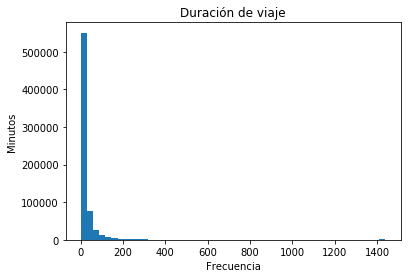

In [16]:
plt.hist(train.duration, bins=50)
plt.title("Duración de viaje")
plt.xlabel("Frecuencia")
plt.ylabel("Minutos")
plt.show()

Vemos que hay algunos con duración igual a 1440. Es decir, un día entero (24 horas * 60 minutos = 1440). ¿Qué pasó esos viajes?

In [17]:
train[train.duration == 1440]

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,passholder_type,start_station,end_station,never_delivered
40,110113350,1440,2018-11-23 09:37:00,2018-11-24 16:44:00,0.000000,0.000000,0.000000,0.000000,12227,One Way,Walk-up,4215,3000,True
230,137752372,1440,2020-02-17 13:30:00,2020-02-18 16:17:00,33.984928,-118.469963,33.984341,-118.471550,15346,One Way,One Day Pass,4347,4346,False
959,116879020,1440,2019-03-05 13:44:00,2019-03-06 17:03:00,0.000000,0.000000,0.000000,0.000000,16079,One Way,Walk-up,4322,3000,True
1369,104612956,1440,2018-09-01 15:06:00,2018-09-03 16:24:00,0.000000,0.000000,0.000000,0.000000,12356,One Way,Walk-up,3010,3000,True
2141,104549294,1440,2018-08-31 15:47:00,2018-09-02 14:42:00,0.000000,0.000000,0.000000,0.000000,05974,One Way,Walk-up,3031,3000,True
2635,126292909,1440,2019-07-26 16:47:00,2019-07-28 10:46:00,0.000000,0.000000,0.000000,0.000000,16763,One Way,Walk-up,3032,3000,True
2650,128163702,1440,2019-08-27 17:07:00,2019-08-29 07:46:00,0.000000,0.000000,0.000000,0.000000,6595,One Way,Walk-up,4126,3000,True
2796,46112491,1440,2017-09-14 03:37:00,2017-09-15 11:28:00,34.046612,-118.262733,34.026112,-118.238319,5716,One Way,Walk-up,3008,4118,False
3225,166504340,1440,2021-07-14 22:27:00,2021-07-16 05:04:00,0.000000,0.000000,0.000000,0.000000,6386,One Way,One Day Pass,4543,3000,True
3670,141122232,1440,2020-04-18 22:31:00,2020-04-20 15:47:00,34.101891,-118.300613,34.109360,-118.271812,16283,One Way,One Day Pass,4406,4455,False


En realidad, 1440 es un placeholder. Es el valor máximo aceptado por esa columna, puesto que podemos ver viajes que claramente duraron más de un día. No obstante, esto incluye a los viajes sin información de la estación de entrega; es decir, viajes que, posiblemente, nunca finalizaron, ya sea por un error en el sistema, o por robo de las bicicletas.

Sin los viajes con duración igual a 1440, la distribución se ve así:

In [18]:
train["overdue"] = (train.duration == 1440)

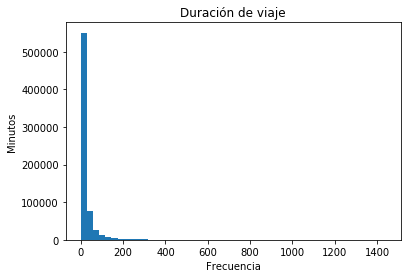

In [19]:
plt.hist(train.loc[~train["overdue"], "duration"], bins=50)
plt.title("Duración de viaje")
plt.xlabel("Frecuencia")
plt.ylabel("Minutos")
plt.show()

¡Siguen habiendo viajes muuuy largos!

Por temas de visualización, vamos a quedarnos sólo con el 95% de los viajes que duraron menos.

In [20]:
train.duration.quantile(0.95)

105.0

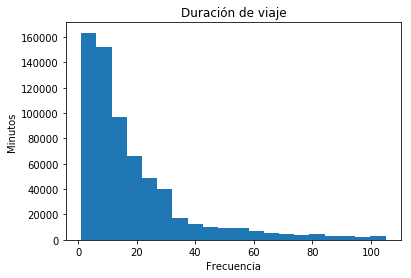

In [21]:
plt.hist(train.loc[train["duration"]<=105, "duration"], bins=20)
plt.title("Duración de viaje")
plt.xlabel("Frecuencia")
plt.ylabel("Minutos")
plt.show()

In [22]:
train["long_duration"] = (train.duration >= 120)
train["long_duration"].mean()

0.04257238064649338

### Distancias
Conocemos la latitud y longitud del inicio y del fin del viaje. Si bien hay viajes redondos (inician y terminan en el mismo punto), para los demás podemos conocer la distancia lineal recorrida.

Lineal, puesto que sólo sabemos la distancia en metros del punto A al B, sin tomar en cuenta las calles que se tuvieron que tomar.

In [23]:
train["distance"] = train.apply(lambda x: hs.haversine((x.start_lat, x.start_lon), \
                                                       (x.end_lat, x.end_lon)), axis=1)

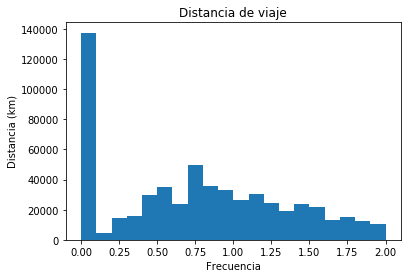

In [24]:
plt.hist(train["distance"][train["distance"]<2], bins=20)
plt.title("Distancia de viaje")
plt.xlabel("Frecuencia")
plt.ylabel("Distancia (km)")
plt.show()

### Fechas utilizadas

Ahora sí, se observan los periodos de tiempo que se están ocupando para el dataset.

In [25]:
train[["start_time", "end_time"]].describe()

,start_time,end_time
count,697424,697424
unique,565702,545733
top,2018-10-03 09:29:00,2018-08-04 12:41:00
freq,12,12
first,2016-10-01 00:48:00,2016-10-01 00:52:00
last,2021-12-31 22:57:00,2022-01-02 08:12:00


### Análisis por día de la semana y hora

Según la fecha de inicio, ¿qué horario y día de la semana son más comúnes?

In [26]:
train["hour"] = train.start_time.dt.hour
train["dayofweek"] = train.start_time.dt.dayofweek

In [27]:
hourday = pd.crosstab(train.dayofweek, train.hour)
hourday.style.background_gradient(cmap='Greens', axis=1)

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
dayofweek,,,,,,,,,,,,,,,,,,,,,,,,
0,800,477,331,187,227,436,1629,3797,5546,4572,4097,5337,6758,6564,6036,6567,7778,9218,7955,6160,4221,2918,1912,1195
1,745,434,283,166,244,565,2005,4340,6354,5301,4404,5628,6966,6657,6091,6699,8358,9778,8414,6508,4531,3097,2124,1256
2,745,439,304,154,236,559,1928,4182,5961,5047,4202,5438,6831,6496,6030,6453,7984,9514,8226,6502,4305,3120,2131,1417
3,760,470,309,154,246,514,1745,3966,5809,5198,4278,5635,6776,6753,6226,6515,8416,9560,8342,6450,4661,3353,2332,1549
4,1010,614,389,206,256,463,1531,3654,5646,5265,4880,6127,7449,7600,7055,7577,8369,9384,7973,6523,4790,3569,2791,2129
5,1565,1067,688,345,197,201,573,1264,2456,3990,5195,6673,7514,8565,8560,8721,8547,7817,7076,5868,4601,3550,2847,2315
6,1491,1198,696,307,215,208,483,1032,2087,4164,5866,7383,8272,8989,9291,8839,8359,7616,6515,5255,3874,2854,1874,1224


Se puede observar una mayor concentración en los horarios de día. 

Entre semana (días 0-4), el horario más común de uso es a las 5 de la tarde, coincidiendo con la salida laboral. 

En fines de semana (días 5 y 6), lo más común es usar la bicicleta entre las 12 y las 16 horas.

In [126]:
train["dayofmonth"] = train.start_time.dt.day

## 2. Modeling

### Creación de variable Objetivo
Antes de modelar, se crea nuestra target.

In [28]:
train["target"] = (train.passholder_type == "Monthly Pass")
train["target"].mean()

0.5660387368372755

### Feature Engineering

Vamos a crear algunas variables extras, basándonos en las observaciones que vimos anteriormente.

In [30]:
# Día de la semana de inicio del viaje
days_of_week = pd.get_dummies(train.dayofweek, prefix="day")
train = pd.concat([train, days_of_week], axis=1)

In [31]:
# Velocidad (Lineal) de traslado
train["speed"] = train["distance"] / train["duration"]

In [32]:
# Viaje redondo
train["round"] = train.trip_route_category == "Round Trip"
train["round"].mean()

0.16843125559200717

In [33]:
# Entre semana / Fin de semana
train["weekend"] = (train["dayofweek"].isin([5,6])) + 0
train["weekend"].mean()

0.2843134162288651

### Separación en sets de entrenamiento y prueba

Al haber una gran dimensionalidad y estar ocupando la computadora local para entrenar el modelo, se usarán sólo el 10% de los datos para fittear los modelos, sacrificando un poco de efectividad, pero ganando mucho en velocidad.

In [165]:
pred_feat = ["day_" + str(n) for n in range(0,7)] + \
            ["duration", "long_duration", "overdue", "distance", "speed", "hour", "weekend", "round", "never_delivered", "dayofmonth"]

X_train, X_test, y_train, y_test = train_test_split(train[pred_feat], 
                                                  train["target"], train_size=0.5, random_state=42)

In [166]:
X_test.shape

(348712, 17)

In [167]:
X_train.shape

(348712, 17)

### Modelado de una Regresión Logística (usando L1 - Lasso para regularización) para crear un modelo inicial.

In [168]:
import warnings
warnings.filterwarnings("ignore")

In [169]:
reg = LogisticRegressionCV(penalty="l1", solver="liblinear", class_weight="balanced")
reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [170]:
print("Train AUC Score:")
roc_auc_score(y_train, reg.predict_proba(X_train)[:, 1])

Train AUC Score:


0.7389233305267633

In [171]:
print("Test AUC Score:")
roc_auc_score(y_test, reg.predict_proba(X_test)[:, 1])

Test AUC Score:


0.739512142097008

In [172]:
reg.coef_

array([[ 7.98891372e-01,  8.66878088e-01,  8.81621388e-01,
         8.38985098e-01,  6.62976108e-01,  3.46523456e-01,
         3.35561350e-01, -2.04428675e-02,  1.76600910e+00,
         2.52089753e+01, -3.37838464e-04, -2.56498255e-04,
        -1.49023557e-02, -1.75476260e-01, -9.46159603e-01,
        -6.22234646e-01, -6.63651998e-04]])

In [173]:
reg.intercept_

array([0.23178318])

Los scores son similares; por lo tanto, no se sospecha de overfit.

### Fit usando LightGBM

In [174]:
cv_params = {"num_iterations":[50, 100, 150],
            "max_depth":[3, 5],
            "learning_rate":[0.05, 0.1, 0.2],
            "num_leaves":[25, 20],
            "metric":["auc"]
}

estimator = lgb.LGBMClassifier(objective="binary",
                               reg_alpha = 0.5,
                               reg_lambda = 0.5,
                               class_weight="balanced", 
                               metric="auc")

gridsearch = GridSearchCV(estimator, cv_params, cv=5)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.5, reg_lambda=0.5, silent='warn', subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_iterations': [50, 100, 150], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [25, 20], 'metric': ['auc']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [175]:
gridsearch.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'metric': 'auc',
 'num_iterations': 150,
 'num_leaves': 25}

In [176]:
params = gridsearch.best_params_
model = lgb.LGBMClassifier(objective="binary", 
                            max_depth = params["max_depth"], 
                            num_iterations = params["num_iterations"],
                            learning_rate = params["learning_rate"],
                            num_leaves = params["num_leaves"],
                            reg_alpha= 0.5,
                            reg_lambda=0.5,
                            class_weight="balanced",
                            metric="auc")

model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.2,
        max_depth=5, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_iterations=150, num_leaves=25, objective='binary',
        random_state=None, reg_alpha=0.5, reg_lambda=0.5, silent='warn',
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [177]:
print("Train AUC Score:")
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

Train AUC Score:


0.7929031124525282

In [178]:
print("Test AUC Score:")
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

Test AUC Score:


0.7862634739763587

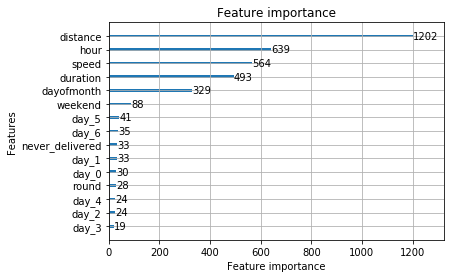

In [179]:
lgb.plot_importance(model)
plt.show()

Nuestro modelo tiene un área bajo la curva de 0.78 para los sets de entrenamiento y prueba. Este resultado es bueno, aunque posiblemente pudiera ser mejorado con el uso de más y mejores variables, así como con el uso de algún otro algoritmo o una mejor selección de parámetros en este.

## 3. Evaluación

### Correlación entre variables finales

Es posible observar que ningun par de nuestras variables predictoras están altamente correlacionas entre sí. Usando la correlación de Pearson, podemos observar a los valores más altos alrededor de 0.43, por lo que se podría afirmar que no hay información que resulte redundante.

In [180]:
corre = train[pred_feat].corr()**2

np.fill_diagonal(corre.values, 0)
corre.style.highlight_max(axis=0)

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,duration,long_duration,overdue,distance,speed,hour,weekend,round,never_delivered,dayofmonth
day_0,0,0.0265969,0.0257555,0.0263106,0.0279319,0.0263653,0.0257213,0.000190192,0.000341464,9.56666e-06,2.55788e-06,2.54952e-06,2.5523e-05,0.0624312,0.000273011,1.12003e-05,1.38716e-05
day_1,0.0265969,0,0.0277362,0.028334,0.03008,0.0283929,0.0276994,0.000414815,0.000523591,3.35791e-05,6.07007e-07,1.0839e-06,0.00010338,0.0672325,0.000840746,8.37202e-05,2.16682e-05
day_2,0.0257555,0.0277362,0,0.0274376,0.0291283,0.0274946,0.0268231,0.000388835,0.000534983,2.31203e-05,4.11574e-06,1.92453e-06,3.22343e-05,0.0651055,0.000894752,0.000121071,6.03523e-06
day_3,0.0263106,0.028334,0.0274376,0,0.0297561,0.0280872,0.0274012,0.000344527,0.000519634,1.64149e-05,6.15446e-06,9.78102e-09,6.60895e-06,0.0665086,0.000804648,7.85279e-05,5.92168e-05
day_4,0.0279319,0.03008,0.0291283,0.0297561,0,0.029818,0.0290897,7.76527e-05,0.000174989,3.85394e-07,1.00406e-06,2.14038e-07,1.62901e-05,0.0706069,0.000223688,2.74173e-05,8.16717e-06
day_5,0.0263653,0.0283929,0.0274946,0.0280872,0.029818,0,0.0274582,0.00131511,0.00123341,0.000124069,4.4263e-07,1.77994e-06,0.000530768,0.422309,0.00240221,8.99941e-05,3.17107e-05
day_6,0.0257213,0.0276994,0.0268231,0.0274012,0.0290897,0.0274582,0,0.00203666,0.00431345,5.1971e-05,1.68403e-05,3.37637e-06,8.17595e-05,0.411995,0.0049143,0.000802055,1.90492e-05
duration,0.000190192,0.000414815,0.000388835,0.000344527,7.76527e-05,0.00131511,0.00203666,0,0.454532,0.527353,1.00008e-05,7.13751e-06,8.82252e-06,0.00396645,0.00817814,0.0830521,8.19119e-06
long_duration,0.000341464,0.000523591,0.000534983,0.000519634,0.000174989,0.00123341,0.00431345,0.454532,0,0.094848,1.05015e-05,6.37732e-06,0.000947293,0.00607248,0.0183287,0.0344913,1.7261e-05
overdue,9.56666e-06,3.35791e-05,2.31203e-05,1.64149e-05,3.85394e-07,0.000124069,5.1971e-05,0.527353,0.094848,0,4.65272e-07,6.97903e-07,4.72828e-05,0.000202128,0.000127154,0.068256,3.50204e-08


Para poder darle interpretabilidad, graficamos la relación entre el score generado y los valores de las variables más importantes:

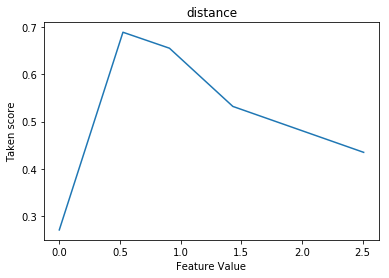

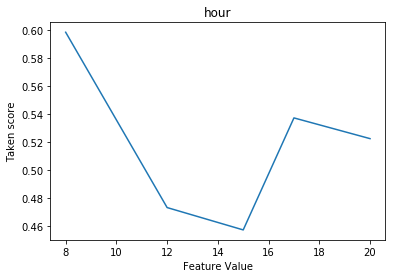

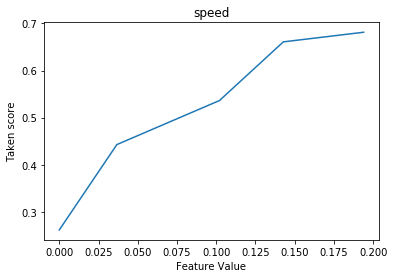

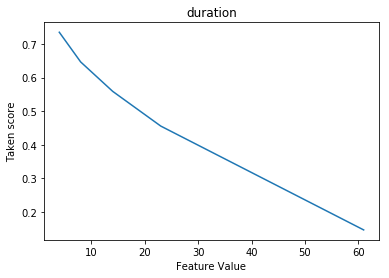

In [181]:
important_feats = ["distance", "hour", "speed", "duration"]

to_plot = X_train[pred_feat].copy()
to_plot["score"] = model.predict_proba(to_plot)[:, 1]

for var in important_feats:
    to_plot["bin"] = pd.qcut(to_plot[var], 5, duplicates="drop")
    plot_x = to_plot.groupby("bin")[var].median()
    plot_y = to_plot.groupby("bin")["score"].mean()

    plt.plot(plot_x, plot_y)
    plt.title(var)
    plt.xlabel("Feature Value")
    plt.ylabel("Taken score")
    plt.show()

### Score en el dataset de prueba

In [144]:
test = pd.read_csv("ds-programming-test/test_set.csv")
test.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
0,17059130,12,1/1/2017 0:24,1/1/2017 0:36,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
1,17059129,17,1/1/2017 0:28,1/1/2017 0:45,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
2,17059126,20,1/1/2017 0:39,1/1/2017 0:59,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
3,17059125,12,1/1/2017 0:43,1/1/2017 0:55,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
4,17061379,48,1/1/2017 0:56,1/1/2017 1:44,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063


#### Feature Engineering

In [150]:
test["start_time"] = pd.to_datetime(test.start_time)
test["end_time"] = pd.to_datetime(test.end_time)
test[["start_time", "end_time"]].head()

,start_time,end_time
0,2017-01-01 00:24:00,2017-01-01 00:36:00
1,2017-01-01 00:28:00,2017-01-01 00:45:00
2,2017-01-01 00:39:00,2017-01-01 00:59:00
3,2017-01-01 00:43:00,2017-01-01 00:55:00
4,2017-01-01 00:56:00,2017-01-01 01:44:00


In [151]:
test["hour"] = test.start_time.dt.hour

test["dayofweek"] = test.start_time.dt.dayofweek
days_of_week = pd.get_dummies(test.dayofweek, prefix="day")
test = pd.concat([test, days_of_week], axis=1)

# Entre semana / Fin de semana
test["weekend"] = (test["dayofweek"].isin([5,6])) + 0
test["weekend"].mean()

0.2842059639998175

In [152]:
test["never_delivered"] = (test.end_lat.isnull())

# Reemplazo TODOS los valores por 0, en caso de que haya algún faltante.
filtro = test.start_lat.isnull() | test.end_lat.isnull()
test.loc[filtro, ["start_lat", "start_lon", "end_lat", "end_lon"]] = 0

In [153]:
test["overdue"] = (test.duration == 1440)
test["long_duration"] = (test.duration >= 120)

In [154]:
test["distance"] = test.apply(lambda x: hs.haversine((x.start_lat, x.start_lon), \
                                                       (x.end_lat, x.end_lon)), axis=1)

In [155]:
# Velocidad (Lineal) de traslado
test["speed"] = test["distance"] / test["duration"]

In [156]:
# Viaje redondo
test["round"] = test.trip_route_category == "Round Trip"
test["round"].mean()

0.1688565783332105

In [159]:
test["dayofmonth"] = test.start_time.dt.day

In [187]:
predictions = model.predict_proba(test[pred_feat])[:, 0]
predictions.mean()

0.48347309593787907

In [188]:
test["passholder_type"] = np.where(predictions<0.5, "Monthly Pass", "Walk-up")

In [189]:
(test["passholder_type"] == "Monthly Pass").mean()

0.603132907283211

In [190]:
(train["passholder_type"] == "Monthly Pass").mean()

0.5660387368372755

In [191]:
test[["trip_id", "passholder_type"]].to_csv("Results2.csv", index=False)